# Car racing problem

## Bibliografy
https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN;
https://github.com/wpiszlogin/driver_critic/blob/main/base_solution.py; 
https://www.gymlibrary.ml/environments/box2d/car_racing/

## Initialize and install the dependencies

In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import os

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
# from docutils.nodes import topic
# from tools import *


## Description
The easiest control task to learn from pixels - a top-down racing environment. The generated track is random every episode.

Some indicators are shown at the bottom of the window along with the state RGB buffer. From left to right: true speed, four ABS sensors, steering wheel position, and gyroscope.

In [2]:
# We use version 0 as the original version
# This cell describes the characteristics of the problem
# We create the environment 
problem = "CarRacing-v0"
env = gym.make(problem)

num_states = env.observation_space.shape[0]

print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
action_space = env.action_space
print("Size of Action Space ->  {}".format(num_actions))

print("Actions are ->  {}".format(action_space))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

observation_upper_bound = env.observation_space.high[0][0][0]
observation_lower_bound = env.observation_space.low[0][0][0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

print("Max Value of Observation ->  {}".format(observation_upper_bound))
print("Min Value of Observation ->  {}".format(observation_lower_bound))

Size of State Space ->  96
Size of Action Space ->  3
Actions are ->  Box([-1.  0.  0.], [1. 1. 1.], (3,), float32)
Max Value of Action ->  1.0
Min Value of Action ->  -1.0
Max Value of Observation ->  255
Min Value of Observation ->  0


##Action space
As observed, there are three actions:

*   Turn (-1 left and +1 is right)
*   Accelerate
*   Breaking

##Observation space
The observation space (the image) is 96x96 pixels


##Rewards
The reward is -0.1 every frme and +1000/N for every track visited, where N is the total number of tiles visited in the track. For example, if you have finished in 732 frames, your reward is 1000 - 0.1*732 = 926.8 points.

If the car goes outside the playfield, it receives -100 reward and dies.

##Actor-critic and policy definition
Actor-critic learning is a reinforcement-learning technique in which you simultaneously learn a policy function and a value function. The policy function tells you how to make decisions, and the value function helps improve the training process for the value function.

The actor takes as input the state and outputs the best action. It essentially controls how the agent behaves by learning the optimal policy (policy-based). The critic, on the other hand, evaluates the action by computing the value function (value based). Those two models participate in a game where they both get better in their own role as the time passes. The result is that the overall architecture will learn to play the game more efficiently than the two methods separately.

In the following two boxes we define the actor and the critic. 

### Actor

In [3]:
# We build here the behaviour of the actor
def build_actor(state_shape, name="Actor"):
      inputs = layers.Input(shape=state_shape)
      x = inputs
      x = layers.Conv2D(16, kernel_size=(5, 5), strides=(4, 4), padding='valid', use_bias=False, activation="relu")(x)
      x = layers.Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='valid', use_bias=False, activation="relu")(x)
      x = layers.Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='valid', use_bias=False, activation="relu")(x)

      x = layers.Flatten()(x)
      x = layers.Dense(64, activation='relu')(x)
      last_init = tf.random_uniform_initializer(minval=-0.005, maxval=0.005)
      y = layers.Dense(num_actions, activation='tanh')(x)

      model = Model(inputs=inputs, outputs=y, name=name)
      model.summary()
      return model

###Critic
The value function is the critic: it tracks whether the agent is ahead or behind in the course of the game. That feedback guides the training process, in the same way that a game review can guide your own study.




In [4]:
# We build here the behaviour of the Critic.
def build_critic(state_shape, name="Critic"):
    state_inputs = layers.Input(shape=state_shape)
    x = state_inputs
    x = layers.Conv2D(16, kernel_size=(5, 5), strides=(4, 4), padding='valid', use_bias=False, activation="relu")(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='valid', use_bias=False, activation="relu")(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='valid', use_bias=False, activation="relu")(x)

    x = layers.Flatten()(x)
    action_inputs = layers.Input(shape=(num_actions,))
    x = layers.concatenate([x, action_inputs])

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    y = layers.Dense(1)(x)

    model = Model(inputs=[state_inputs, action_inputs], outputs=y, name=name)
    model.summary()
    return model

### Policy
Now we define the policy. The policy is a mapping that selects actions based on the observations from the environment. Typically, the policy is a function approximator with tunable parameters, such as a deep neural network.

In [5]:
# Policy will allow us to get the actions during training
def policy(state, params):
        prep_state = preprocess_state(state)
        if params['actor'] is None:
            init_networks(prep_state.shape, params)

        # Get result from a network
        tensor_state = tf.expand_dims(tf.convert_to_tensor(prep_state), 0)
        actor_output = params['actor'](tensor_state).numpy()

        # Add noise
        actor_output = actor_output[0] + params['noise']()
        env_action = actor_output

        # Clip min-max
        env_action = np.clip(np.array(env_action), a_min= action_space.low, a_max= action_space.high)
        return env_action, actor_output

In [6]:
# We initialize the networks for the first step
def init_networks(state_shape, params):
    # Networks initialization
    params['actor']  = build_actor(state_shape)
    params['critic'] = build_critic(state_shape)
    
    # Build target networks in the same way
    params['target_actor']  = build_actor(state_shape, name='TargetActor')
    params['target_critic'] = build_critic(state_shape, name='TargetCritic')
    
    # Copy parameters from action and critic
    params['target_actor'].set_weights(params['actor'].get_weights())
    params['target_critic'].set_weights(params['critic'].get_weights())

In [7]:
# Preprocess the images (state)
def preprocess_state(img, greyscale=False):
      img = img.copy()
      # Remove numbers and enlarge speed bar
      for i in range(88, 93+1):
          img[i, 0:12, :] = img[i, 12, :]

      # Unify grass color
      r1, g1, b1 = (102, 229, 102)
      r2, g2, b2 = (102, 204, 102)

      red, green, blue = img[:,:,0], img[:,:,1], img[:,:,2]
      mask = (red == r1) & (green == g1) & (blue == b1)
      img[:,:,:3][mask] = [r2, g2, b2]

      # Make car black
      car_color = 68.0
      car_area = img[67:77, 42:53]
      car_area[car_area == car_color] = 0

      # Scale from 0 to 1
      img = img / img.max()

      # Unify track color
      img[(img > 0.411) & (img < 0.412)] = 0.4
      img[(img > 0.419) & (img < 0.420)] = 0.4

      # Change color of kerbs
      game_screen = img[0:83, :]
      game_screen[game_screen == 1] = 0.80
      return img

# Start the training

## Initialize hyper parameters, memory buffer and noise generation

In [8]:
class MemoriesRecorder:
    def __init__(self, memory_capacity=50000):
        self.memory_capacity = memory_capacity

        # Memory will be initialized when first time used
        self.state_db     = None
        self.action_db    = None
        self.reward_db    = None
        self.new_state_db = None

        self.writes_num = 0

    def init_memory(self, state_shape, action_shape):
        state_shape  = prepend_tuple(self.memory_capacity, state_shape)
        action_shape = prepend_tuple(self.memory_capacity, action_shape)

        self.state_db     = np.zeros(state_shape, np.float32)
        self.action_db    = np.zeros(action_shape, np.float32)
        self.reward_db    = np.zeros((self.memory_capacity, 1), np.float32)
        self.new_state_db = np.zeros(state_shape, np.float32)

    def write(self, state, action, reward, new_state):
        if self.state_db is None:
            self.init_memory(state.shape, action.shape)

        # Write indexes
        memory_index = self.writes_num     % self.memory_capacity
        next_index   = (self.writes_num + 1) % self.memory_capacity

        # Save next state to the same array with a next index
        self.state_db[memory_index] = state
        self.action_db[memory_index]    = action
        self.reward_db[memory_index]    = reward
        self.new_state_db[memory_index] = new_state

        self.writes_num += 1

    def sample(self, batch_size=64):
        indexes_range = min(self.memory_capacity, self.writes_num)
        sampled_indexes = np.random.choice(indexes_range, batch_size)

        return (self.state_db[sampled_indexes],
                self.action_db[sampled_indexes],
                self.reward_db[sampled_indexes],
                self.new_state_db[sampled_indexes])

# Inserts a new element to the beginning of a tuple.

def prepend_tuple(new_dim, some_shape):
    some_shape_list = list(some_shape)
    some_shape_list.insert(0, new_dim)
    return tuple(some_shape_list)

In [9]:
#We use the same noise function as the one explained in lecture for ddpg_mountaincar_comt
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
            

In [10]:
def learn(state, train_action, reward, new_state, params):
        # Store transition in R
        prep_state     = preprocess_state(state)
        prep_new_state = preprocess_state(new_state)
        params['r_buffer'].write(prep_state, train_action, reward, prep_new_state)

        # Sample mini-batch from R
        state_batch, action_batch, reward_batch, new_state_batch  = params['r_buffer'].sample()

        state_batch     = tf.convert_to_tensor(state_batch)
        action_batch    = tf.convert_to_tensor(action_batch)
        reward_batch    = tf.convert_to_tensor(reward_batch)
        reward_batch    = tf.cast(reward_batch, dtype=tf.float32)
        new_state_batch = tf.convert_to_tensor(new_state_batch)

        update_actor_critic(state_batch, action_batch, reward_batch, new_state_batch, params)

        # Update target networks
        update_target_network(params['target_actor'].variables, params['actor'].variables)
        update_target_network(params['target_critic'].variables, params['critic'].variables)

In [11]:
@tf.function
def update_actor_critic(state, action, reward, new_state, params):
    # Update critic
    with tf.GradientTape() as tape:
        # Calc y
        new_action = params['target_actor'](new_state, training=True)
        y = reward + params['gamma'] * params['target_critic']([new_state, new_action], training=True)

        critic_loss = tf.math.reduce_mean(tf.square(y - params['critic']([state, action], training=True)))

    critic_gradients = tape.gradient(critic_loss, params['critic'].trainable_variables)
    #critic_opt = params['critic_opt']
    params['critic_opt'].apply_gradients(zip(critic_gradients, params['critic'].trainable_variables)) 

    # Update actor
    with tf.GradientTape() as tape:
        critic_out = params['critic']([state, params['actor'](state, training=True)], training=True)
        actor_loss = -tf.math.reduce_mean(critic_out)  # Need to maximize

    actor_gradients = tape.gradient(actor_loss, params['actor'].trainable_variables)
    params['actor_opt'].apply_gradients(zip(actor_gradients, params['actor'].trainable_variables))

@tf.function
def update_target_network(target_weights, new_weights):
    for t, n in zip(target_weights, new_weights):
        t.assign((1 - params['tau']) * t + params['tau'] * n)

In [12]:
 # Training Hyperparameters
params = {
    'gamma': 0.99,
    'actor_lr': 0.00001,
    'critic_lr': 0.002,
    'actor_opt': None,
    'critic_opt': None,
    'actor': None,
    'target_actor': None,
    'target_critic': None,
    'critic': None,
    'tau': 0.005,
    'memory_capacity': 60000,
    'n_episodes': 4000,
    'std_dev': [0.1,4*0.2],
    'noise': None,
    'r_buffer': None,
    'all_episode_reward': [],
    'preview': False,
    'best_result': 0,
    'all_average_reward': [],
}

params['actor_opt'] = Adam(params['actor_lr'])
params['critic_opt'] = Adam(params['critic_lr'])
params['r_buffer'] = MemoriesRecorder(params['memory_capacity'])
params['noise'] = OUActionNoise(mean=np.zeros(1), std_deviation=float(params['std_dev']) * np.ones(1))


## Start training loop

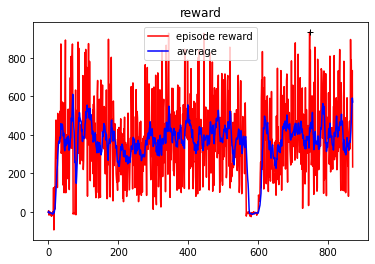

Track generation: 1102..1387 -> 285-tiles track
Iteration:  871 --Last result: 245.34366197183206 Average results: 548.6717544826364
Track generation: 1219..1528 -> 309-tiles track
Iteration:  872 --Last result: 322.47012987012516 Average results: 537.487411537447
Track generation: 1080..1354 -> 274-tiles track
Iteration:  873 --Last result: 892.6739926739792 Average results: 594.0085945886298
Track generation: 1209..1515 -> 306-tiles track
Iteration:  874 --Last result: 324.0278688524538 Average results: 536.772392304201
Track generation: 1206..1520 -> 314-tiles track
Iteration:  875 --Last result: 110.55974440894727 Average results: 481.9894405706006
Track generation: 1080..1354 -> 274-tiles track
Iteration:  876 --Last result: 448.4205128205057 Average results: 447.9016025537594
Track generation: 1151..1443 -> 292-tiles track
Iteration:  877 --Last result: 419.3360824742208 Average results: 424.2350221219373
Track generation: 1249..1566 -> 317-tiles track


KeyboardInterrupt: 

In [13]:
# Loop of episodes
path='../models/'
count_break = 0
last_best = 0
for ie in range(params['n_episodes']):
    #  Before starting, the environment must be reset.
    # This function returns the first observation of the environment.
    state = env.reset()
    params['noise'].reset()
    done = False
    episode_reward = 0
    no_reward_counter = 0

    # One-step-loop
    while not done:
        action, train_action = policy(state, params)

        # This will make steering much easier
        action /= 4
        new_state, reward, done, info = env.step(action)

        # Models action output has a different shape for this problem
        #updated_actor, updated_critic, updated_target_network_actor, updated_target_network_critic = 
        with tf.device("/gpu:0"):
            learn(state, train_action, reward, new_state, params)
            state = new_state
            episode_reward += reward

        if reward < 0:
            no_reward_counter += 1
            if no_reward_counter > 200:
                
                break
        else:
            no_reward_counter = 0

    params['all_episode_reward'].append(episode_reward)
    params['all_average_reward'].append(np.array(params['all_episode_reward'][-10:]).mean())
    print('Iteration: ', ie, '--Last result:', episode_reward, 'Average results:', params['all_average_reward'][ie])

    path_n = os.path.join(path, 'model_plots_' + str(count_break))
        
    if episode_reward > params['best_result']:
        if  not os.path.isdir(path_n):
            os.mkdir(path_n)
        print('Saving best solution')
        count_break += 1
        last_best = ie
        params['actor'].save(os.path.join(path_n, 'actor.h5'))
        params['critic'].save(os.path.join(path_n, 'critic.h5'))
        params['target_actor'].save(os.path.join(path_n, 'target_actor.h5'))
        params['target_critic'].save(os.path.join(path_n, 'target_critic.h5'))
        params['best_result'] = episode_reward

    if not ie % 10:
        if  not os.path.isdir(path_n):
            os.mkdir(path_n)
        clear_output(wait=True)
        plt.figure()
        plt.title('reward')
        plt.plot(params['all_episode_reward'], label='episode reward', color='r')
        plt.plot(params['all_average_reward'], label='average', color='b')
        plt.plot([last_best],[params['all_episode_reward'][last_best]], color='k', marker='+')
        plt.legend()
        plt.savefig(os.path.join(path_n, f'episode_reward_and_average_{count_break}.png'))
        plt.show()
        plt.close()